In [70]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from pathlib import Path

# ==========================================================
# 1. CREATE SMALL SUBSETS
# ==========================================================
def create_subset(input_csv, output_csv, image_dir, n=64, mode="train"):
    df = pd.read_csv(input_csv)
    
    if mode in ["train", "valid"]:
        df = df.dropna(subset=["iauname", "label", "petroRad_r_psf"])
        df["filename"] = df["iauname"].apply(lambda x: os.path.basename(x))
    elif mode == "test":
        df = df.dropna(subset=["filename", "label", "petroRad_r_psf", "asset_id"])
        df["filename"] = df["asset_id"].astype(str) + ".png"
    
    all_image_paths = list(Path(image_dir).rglob("*.png"))
    filename_to_path = {p.name: str(p) for p in all_image_paths}
    
    df["filepath"] = df["filename"].map(filename_to_path)
    df = df[df["filepath"].notnull()].reset_index(drop=True)
    
    if len(df) == 0:
        print(f"⚠️ WARNING: No images found for {input_csv}")
        return df
    
    subset = df.sample(n=min(n, len(df)), random_state=42).reset_index(drop=True)
    cols_to_keep = ["filepath", "label", "petroRad_r_psf"]
    subset.to_csv(output_csv, index=False, columns=cols_to_keep)
    print(f"Subset saved → {output_csv} with {len(subset)} rows")
    return subset

IMAGE_DIR  = "/Users/apple/Desktop/Galaxy_research/image/"
df_train = create_subset("csv_files/df_train_plus_petroRad_r.csv", 
                         "df_train_small.csv", IMAGE_DIR, 64, mode="train")
df_valid = create_subset("csv_files/df_valid_plus_petroRad_r.csv", 
                         "df_valid_small.csv", IMAGE_DIR, 64, mode="valid")
# Fallback: use validation as test set for now
df_test  = df_valid.copy()

# ==========================================================
# 2. DATA GENERATOR
# ==========================================================
class CustomDataGeneratorIMG(tf.keras.utils.Sequence):
    def __init__(self, dataframe, batch_size, input_size=(207,207,3), shuffle=False):
        self.dataframe = dataframe.copy()
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.n = len(self.dataframe)

    def __len__(self):
        return self.n // self.batch_size

    def on_epoch_end(self):
        if self.shuffle:
            self.dataframe = self.dataframe.sample(frac=1).reset_index(drop=True)

    from tensorflow.keras.applications.resnet50 import preprocess_input
    def __get_image(self, path):
        image = tf.keras.preprocessing.image.load_img(path)
        image_arr = tf.keras.preprocessing.image.img_to_array(image)
        image_arr = tf.image.resize_with_crop_or_pad(image_arr, 207, 207)
        return image_arr
    
    def __getitem__(self, index):
        batches = self.dataframe[index*self.batch_size:(index+1)*self.batch_size]
        x0_batch = np.asarray([self.__get_image(f) for f in batches['filepath']])
        y_batch = batches['label'].values
        return x0_batch, y_batch

# ==========================================================
# 3. BUILD MODEL + LOAD WEIGHTS
# ==========================================================
print("Building model...")
base_model = ResNet50(include_top=False, weights=None, input_shape=(207,207,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(2, activation='softmax')(x)
resnet_50 = keras.Model(inputs=base_model.input, outputs=output)

weights_path = "weights/best.weights.h5"
resnet_50.load_weights(weights_path)
print(f"Weights loaded: {weights_path}")

# ==========================================================
# 4. RUN PREDICTIONS
# ==========================================================
batch_size = 16
test_gen = CustomDataGeneratorIMG(df_test, batch_size=batch_size)

print("Running predictions...")
probabilities = resnet_50.predict(test_gen, verbose=1)
predictions = np.argmax(probabilities, axis=1)

df_pred = df_test.copy()
df_pred["pred_label"] = predictions
df_pred["p0"] = probabilities[:,0]
df_pred["p1"] = probabilities[:,1]
df_pred.to_csv("predictions_small.csv", index=False)
print("Predictions saved to predictions_small.csv")

# ==========================================================
# 5. BIAS METRIC (2014)
# ==========================================================
def estimate_bias(df, label_col="label", NA_j=10, mode=1, mode1=1):
    alfa_tmp = df["petroRad_r_psf"].values
    alfa_tmp.sort()
    num_per_bin = max(1, int(len(df)/NA_j))
    limits = [alfa_tmp[num_per_bin*i] for i in range(min(NA_j, len(df)))] + [alfa_tmp[-1]+1]

    n_el = (df[label_col]==0).sum()
    n_cs = (df[label_col]==1).sum()
    r_el = n_el / (n_el+n_cs)
    r_cs = n_cs / (n_el+n_cs)

    sigma_el, sigma_cs = 0,0
    for i in range(NA_j):
        bin_mask = (df["petroRad_r_psf"]>=limits[i]) & (df["petroRad_r_psf"]<limits[i+1])
        denom = bin_mask.sum()
        if denom==0: continue
        rj_el = (df.loc[bin_mask,label_col]==0).sum()/denom
        rj_cs = (df.loc[bin_mask,label_col]==1).sum()/denom
        sigma_el += (rj_el-r_el)**2
        sigma_cs += (rj_cs-r_cs)**2
    return np.sqrt((sigma_el+sigma_cs)/(2*NA_j))

L_orig = estimate_bias(df_test, label_col="label")
L_pred = estimate_bias(df_pred, label_col="pred_label")
print(f"Bias2014 → Original={L_orig:.4f}, Predicted={L_pred:.4f}")

# ==========================================================
# 6. BIAS METRIC (2018)
# ==========================================================
from sklearn.linear_model import LinearRegression

def estimate_bias2018(df, label_col="label", NA_j=10):
    """
    Simplified 2018 bias metric:
    - Bin galaxies by petroRad_r_psf (alpha proxy)
    - Compute fraction of class=1 per bin
    - Fit linear regression of fraction vs alpha
    - Return slope magnitude as bias indicator
    """
    # Sort and bin by petroRad_r_psf
    alfa_tmp = np.sort(df["petroRad_r_psf"].values)
    num_per_bin = max(1, int(len(df)/NA_j))
    limits = [alfa_tmp[num_per_bin*i] for i in range(min(NA_j, len(df)))] + [alfa_tmp[-1]+1]

    fractions, alphas = [], []
    for i in range(NA_j):
        bin_mask = (df["petroRad_r_psf"] >= limits[i]) & (df["petroRad_r_psf"] < limits[i+1])
        denom = bin_mask.sum()
        if denom == 0:
            continue
        frac = (df.loc[bin_mask, label_col] == 1).sum() / denom
        fractions.append(frac)
        alphas.append(df.loc[bin_mask, "petroRad_r_psf"].mean())

    if len(fractions) < 2:
        return 0.0

    # Linear regression: fraction ~ alpha
    X = np.array(alphas).reshape(-1,1)
    y = np.array(fractions)
    model = LinearRegression().fit(X,y)
    slope = model.coef_[0]

    return abs(slope)

L2018_orig = estimate_bias2018(df_test, label_col="label")
L2018_pred = estimate_bias2018(df_pred, label_col="pred_label")
print(f"Bias2018 → Original={L2018_orig:.4f}, Predicted={L2018_pred:.4f}")

Subset saved → df_train_small.csv with 64 rows
Subset saved → df_valid_small.csv with 64 rows
Building model...
Weights loaded: weights/best.weights.h5
Running predictions...


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
Predictions saved to predictions_small.csv
Bias2014 → Original=0.1516, Predicted=0.0556
Bias2018 → Original=0.9094, Predicted=0.9806


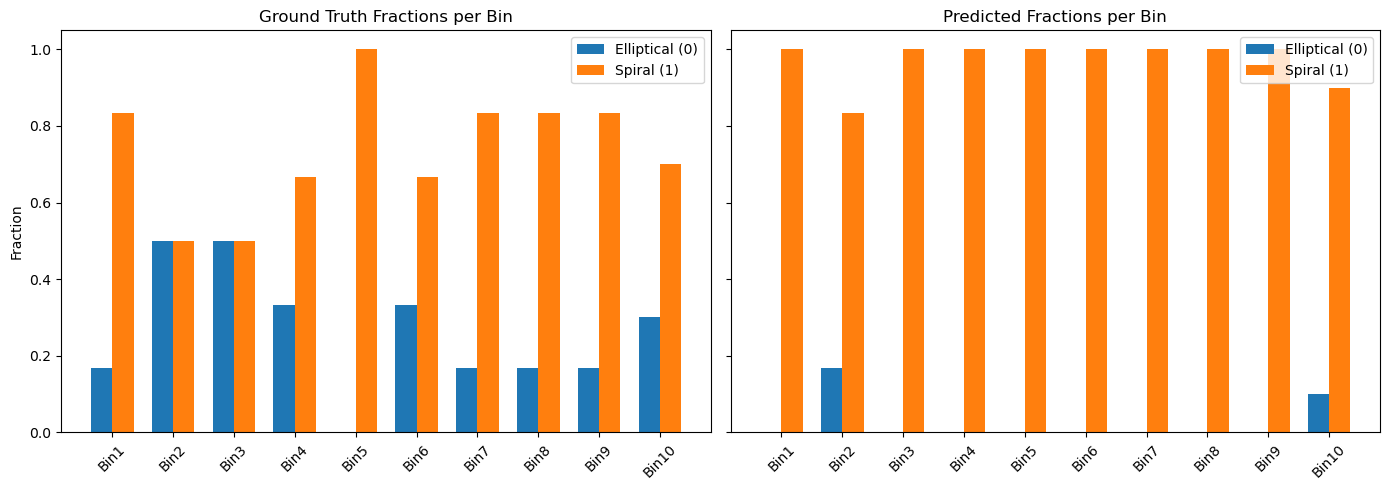

In [72]:
import matplotlib.pyplot as plt
import numpy as np

def plot_bias_histograms(df_true, df_pred, NA_j=10):
    # Bin edges based on petroRad_r_psf quantiles
    alfa_tmp = df_true["petroRad_r_psf"].values
    alfa_tmp.sort()
    num_per_bin = max(1, int(len(df_true)/NA_j))
    limits = [alfa_tmp[num_per_bin*i] for i in range(min(NA_j, len(df_true)))] + [alfa_tmp[-1]+1]

    bin_labels = []
    true_el, true_cs = [], []
    pred_el, pred_cs = [], []

    for i in range(NA_j):
        bin_mask = (df_true["petroRad_r_psf"] >= limits[i]) & (df_true["petroRad_r_psf"] < limits[i+1])
        denom = bin_mask.sum()
        if denom == 0:
            continue

        # Ground truth fractions
        rj_el = (df_true.loc[bin_mask,"label"]==0).sum()/denom
        rj_cs = (df_true.loc[bin_mask,"label"]==1).sum()/denom
        true_el.append(rj_el)
        true_cs.append(rj_cs)

        # Predicted fractions
        rj_el_p = (df_pred.loc[bin_mask,"pred_label"]==0).sum()/denom
        rj_cs_p = (df_pred.loc[bin_mask,"pred_label"]==1).sum()/denom
        pred_el.append(rj_el_p)
        pred_cs.append(rj_cs_p)

        bin_labels.append(f"Bin{i+1}")

    x = np.arange(len(bin_labels))
    width = 0.35

    fig, ax = plt.subplots(1,2, figsize=(14,5), sharey=True)

    # Ground truth
    ax[0].bar(x - width/2, true_el, width, label="Elliptical (0)")
    ax[0].bar(x + width/2, true_cs, width, label="Spiral (1)")
    ax[0].set_xticks(x)
    ax[0].set_xticklabels(bin_labels, rotation=45)
    ax[0].set_title("Ground Truth Fractions per Bin")
    ax[0].set_ylabel("Fraction")
    ax[0].legend()

    # Predicted
    ax[1].bar(x - width/2, pred_el, width, label="Elliptical (0)")
    ax[1].bar(x + width/2, pred_cs, width, label="Spiral (1)")
    ax[1].set_xticks(x)
    ax[1].set_xticklabels(bin_labels, rotation=45)
    ax[1].set_title("Predicted Fractions per Bin")
    ax[1].legend()

    plt.tight_layout()
    plt.show()

# Run plotting
plot_bias_histograms(df_test, df_pred, NA_j=10)

In [56]:
print(df_pred[["p0","p1"]].head(10))
print(df_pred[["p0","p1"]].describe())

         p0        p1
0  0.457933  0.542067
1  0.457905  0.542095
2  0.457981  0.542019
3  0.458013  0.541987
4  0.457650  0.542350
5  0.457877  0.542123
6  0.457947  0.542053
7  0.458043  0.541957
8  0.457595  0.542405
9  0.457965  0.542035
              p0         p1
count  64.000000  64.000000
mean    0.457875   0.542125
std     0.000144   0.000144
min     0.457417   0.541957
25%     0.457857   0.542035
50%     0.457932   0.542069
75%     0.457965   0.542143
max     0.458043   0.542583


Subset saved → df_train_small.csv with 64 rows
Subset saved → df_valid_small.csv with 64 rows
Building model...


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 40s 7s/step - accuracy: 0.4958 - loss: 1.3027 - val_accuracy: 0.2656 - val_loss: 3.5190
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - accuracy: 0.5333 - loss: 0.9103 - val_accuracy: 0.7344 - val_loss: 0.5768
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 6s/step - accuracy: 0.5583 - loss: 0.8043 - val_accuracy: 0.2812 - val_loss: 1.2449
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 5s/step - accuracy: 0.6458 - loss: 0.7015 - val_accuracy: 0.4688 - val_loss: 0.7141
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 5s/step - accuracy: 0.6875 - loss: 0.4741 - val_accuracy: 0.7344 - val_loss: 0.6385
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.8229 - loss: 0.5394 - val_accuracy: 0.5781 - val_loss: 0.6773
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - accuracy: 0.7500 - loss: 0.3972 - val_accuracy: 0.7344 - val_loss: 0.6152
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 7s/step - accuracy: 0.8271 - loss: 0.3091 - val_accuracy: 0.6719 - val_loss: 0.6673
Epoch 9/

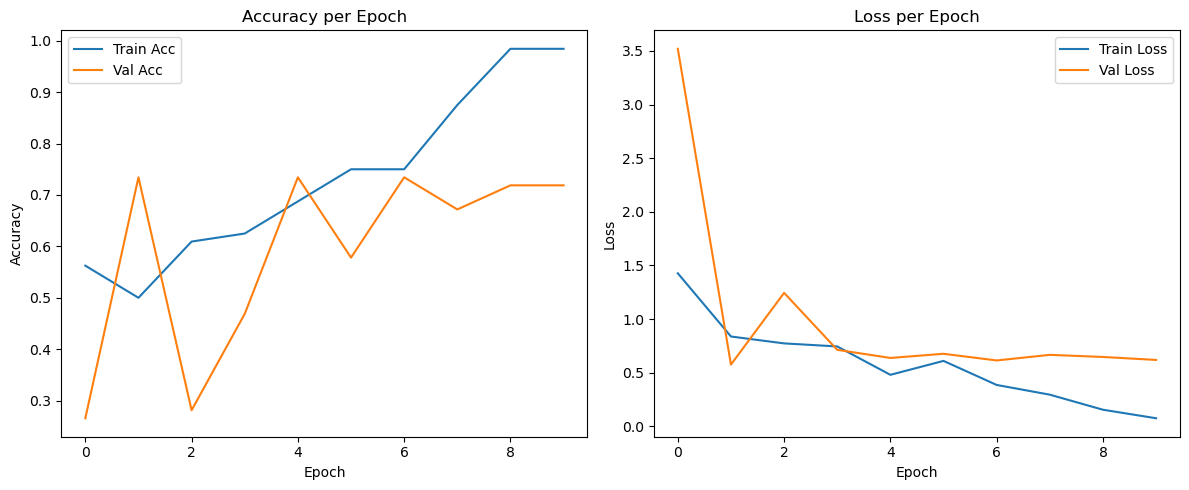

Running predictions...
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 903ms/step
Predictions saved to predictions_small.csv
Bias2014 → Original=0.1516, Predicted=0.0500
Bias2018 → Original=0.9094, Predicted=0.5303


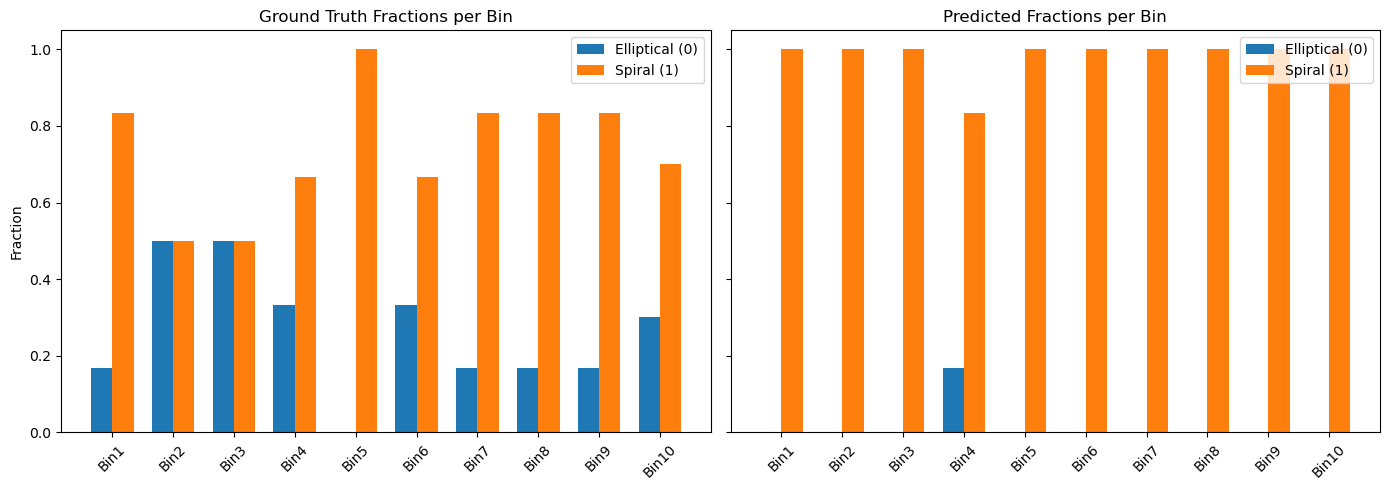

In [7]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import pickle

# ==========================================================
# 1. CREATE SMALL SUBSETS
# ==========================================================
def create_subset(input_csv, output_csv, image_dir, n=64, mode="train"):
    df = pd.read_csv(input_csv)
    
    if mode in ["train", "valid"]:
        df = df.dropna(subset=["iauname", "label", "petroRad_r_psf"])
        df["filename"] = df["iauname"].apply(lambda x: os.path.basename(x))
    elif mode == "test":
        df = df.dropna(subset=["filename", "label", "petroRad_r_psf", "asset_id"])
        df["filename"] = df["asset_id"].astype(str) + ".png"
    
    all_image_paths = list(Path(image_dir).rglob("*.png"))
    filename_to_path = {p.name: str(p) for p in all_image_paths}
    
    df["filepath"] = df["filename"].map(filename_to_path)
    df = df[df["filepath"].notnull()].reset_index(drop=True)
    
    if len(df) == 0:
        print(f"⚠️ WARNING: No images found for {input_csv}")
        return df
    
    subset = df.sample(n=min(n, len(df)), random_state=42).reset_index(drop=True)
    cols_to_keep = ["filepath", "label", "petroRad_r_psf"]
    subset.to_csv(output_csv, index=False, columns=cols_to_keep)
    print(f"Subset saved → {output_csv} with {len(subset)} rows")
    return subset

IMAGE_DIR  = "/Users/apple/Desktop/Galaxy_research/image/"
df_train = create_subset("csv_files/df_train_plus_petroRad_r.csv", 
                         "df_train_small.csv", IMAGE_DIR, 64, mode="train")
df_valid = create_subset("csv_files/df_valid_plus_petroRad_r.csv", 
                         "df_valid_small.csv", IMAGE_DIR, 64, mode="valid")
df_test  = df_valid.copy()   # fallback

# ==========================================================
# 2. DATA GENERATOR
# ==========================================================
class CustomDataGeneratorIMG(tf.keras.utils.Sequence):
    def __init__(self, dataframe, batch_size, input_size=(207,207,3), shuffle=False):
        self.dataframe = dataframe.copy()
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.n = len(self.dataframe)

    def __len__(self):
        return self.n // self.batch_size

    def on_epoch_end(self):
        if self.shuffle:
            self.dataframe = self.dataframe.sample(frac=1).reset_index(drop=True)

    def __get_image(self, path):
        image = tf.keras.preprocessing.image.load_img(path)
        image_arr = tf.keras.preprocessing.image.img_to_array(image)
        image_arr = tf.image.resize_with_crop_or_pad(image_arr, 207, 207)
        return image_arr
    
    def __getitem__(self, index):
        batches = self.dataframe[index*self.batch_size:(index+1)*self.batch_size]
        x0_batch = np.asarray([self.__get_image(f) for f in batches['filepath']])
        y_batch = batches['label'].values
        return x0_batch, y_batch

# ==========================================================
# 3. BUILD MODEL
# ==========================================================
print("Building model...")
base_model = ResNet50(include_top=False, weights=None, input_shape=(207,207,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(2, activation='softmax')(x)
resnet_50 = keras.Model(inputs=base_model.input, outputs=output)

resnet_50.compile(optimizer=keras.optimizers.Adam(1e-4),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

# ==========================================================
# 3b. TRAIN MODEL
# ==========================================================
train_gen = CustomDataGeneratorIMG(df_train, batch_size=16, shuffle=True)
valid_gen = CustomDataGeneratorIMG(df_valid, batch_size=16, shuffle=False)

history = resnet_50.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=10,   # adjust as needed
    verbose=1
)

# Save weights + history
os.makedirs("weights", exist_ok=True)
resnet_50.save_weights("weights/best.weights.h5")
with open("weights/history.pkl", "wb") as f:
    pickle.dump(history.history, f)

# ==========================================================
# 4. PLOT TRAIN/VAL CURVES
# ==========================================================
def plot_training_curves(history):
    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_curves(history)

# ==========================================================
# 5. RUN PREDICTIONS
# ==========================================================
batch_size = 16
test_gen = CustomDataGeneratorIMG(df_test, batch_size=batch_size)

print("Running predictions...")
probabilities = resnet_50.predict(test_gen, verbose=1)
predictions = np.argmax(probabilities, axis=1)

df_pred = df_test.copy()
df_pred["pred_label"] = predictions
df_pred["p0"] = probabilities[:,0]
df_pred["p1"] = probabilities[:,1]
df_pred.to_csv("predictions_small.csv", index=False)
print("Predictions saved to predictions_small.csv")

# ==========================================================
# 6. BIAS METRICS
# ==========================================================
def estimate_bias(df, label_col="label", NA_j=10):
    alfa_tmp = df["petroRad_r_psf"].values
    alfa_tmp.sort()
    num_per_bin = max(1, int(len(df)/NA_j))
    limits = [alfa_tmp[num_per_bin*i] for i in range(min(NA_j, len(df)))] + [alfa_tmp[-1]+1]

    n_el = (df[label_col]==0).sum()
    n_cs = (df[label_col]==1).sum()
    r_el = n_el / (n_el+n_cs)
    r_cs = n_cs / (n_el+n_cs)

    sigma_el, sigma_cs = 0,0
    for i in range(NA_j):
        bin_mask = (df["petroRad_r_psf"]>=limits[i]) & (df["petroRad_r_psf"]<limits[i+1])
        denom = bin_mask.sum()
        if denom==0: continue
        rj_el = (df.loc[bin_mask,label_col]==0).sum()/denom
        rj_cs = (df.loc[bin_mask,label_col]==1).sum()/denom
        sigma_el += (rj_el-r_el)**2
        sigma_cs += (rj_cs-r_cs)**2
    return np.sqrt((sigma_el+sigma_cs)/(2*NA_j))

def estimate_bias2018(df, label_col="label", NA_j=10):
    alfa_tmp = np.sort(df["petroRad_r_psf"].values)
    num_per_bin = max(1, int(len(df)/NA_j))
    limits = [alfa_tmp[num_per_bin*i] for i in range(min(NA_j, len(df)))] + [alfa_tmp[-1]+1]

    fractions, alphas = [], []
    for i in range(NA_j):
        bin_mask = (df["petroRad_r_psf"] >= limits[i]) & (df["petroRad_r_psf"] < limits[i+1])
        denom = bin_mask.sum()
        if denom == 0: continue
        frac = (df.loc[bin_mask, label_col] == 1).sum() / denom
        fractions.append(frac)
        alphas.append(df.loc[bin_mask, "petroRad_r_psf"].mean())

    if len(fractions) < 2:
        return 0.0

    X = np.array(alphas).reshape(-1,1)
    y = np.array(fractions)
    model = LinearRegression().fit(X,y)
    return abs(model.coef_[0])

L_orig = estimate_bias(df_test, label_col="label")
L_pred = estimate_bias(df_pred, label_col="pred_label")
print(f"Bias2014 → Original={L_orig:.4f}, Predicted={L_pred:.4f}")

L2018_orig = estimate_bias2018(df_test, label_col="label")
L2018_pred = estimate_bias2018(df_pred, label_col="pred_label")
print(f"Bias2018 → Original={L2018_orig:.4f}, Predicted={L2018_pred:.4f}")

# ==========================================================
# 7. PLOT BIAS HISTOGRAMS
# ==========================================================
def plot_bias_histograms(df_true, df_pred, NA_j=10):
    alfa_tmp = df_true["petroRad_r_psf"].values
    alfa_tmp.sort()
    num_per_bin = max(1, int(len(df_true)/NA_j))
    limits = [alfa_tmp[num_per_bin*i] for i in range(min(NA_j, len(df_true)))] + [alfa_tmp[-1]+1]

    bin_labels = []
    true_el, true_cs = [], []
    pred_el, pred_cs = [], []

    for i in range(NA_j):
        bin_mask = (df_true["petroRad_r_psf"] >= limits[i]) & (df_true["petroRad_r_psf"] < limits[i+1])
        denom = bin_mask.sum()
        if denom == 0: continue

        rj_el = (df_true.loc[bin_mask,"label"]==0).sum()/denom
        rj_cs = (df_true.loc[bin_mask,"label"]==1).sum()/denom
        true_el.append(rj_el)
        true_cs.append(rj_cs)

        rj_el_p = (df_pred.loc[bin_mask,"pred_label"]==0).sum()/denom
        rj_cs_p = (df_pred.loc[bin_mask,"pred_label"]==1).sum()/denom
        pred_el.append(rj_el_p)
        pred_cs.append(rj_cs_p)

        bin_labels.append(f"Bin{i+1}")

    x = np.arange(len(bin_labels))
    width = 0.35

    fig, ax = plt.subplots(1,2, figsize=(14,5), sharey=True)

    ax[0].bar(x - width/2, true_el, width, label="Elliptical (0)")
    ax[0].bar(x + width/2, true_cs, width, label="Spiral (1)")
    ax[0].set_xticks(x)
    ax[0].set_xticklabels(bin_labels, rotation=45)
    ax[0].set_title("Ground Truth Fractions per Bin")
    ax[0].set_ylabel("Fraction")
    ax[0].legend()

    ax[1].bar(x - width/2, pred_el, width, label="Elliptical (0)")
    ax[1].bar(x + width/2, pred_cs, width, label="Spiral (1)")
    ax[1].set_xticks(x)
    ax[1].set_xticklabels(bin_labels, rotation=45)
    ax[1].set_title("Predicted Fractions per Bin")
    ax[1].legend()

    plt.tight_layout()
    plt.show()

plot_bias_histograms(df_test, df_pred, NA_j=10)

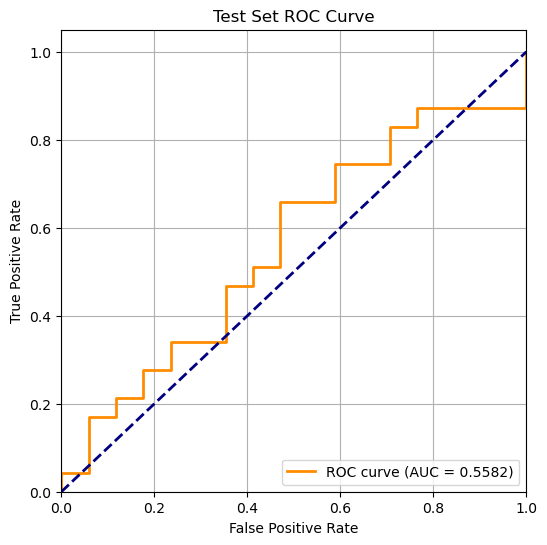

Test AUC: 0.5582


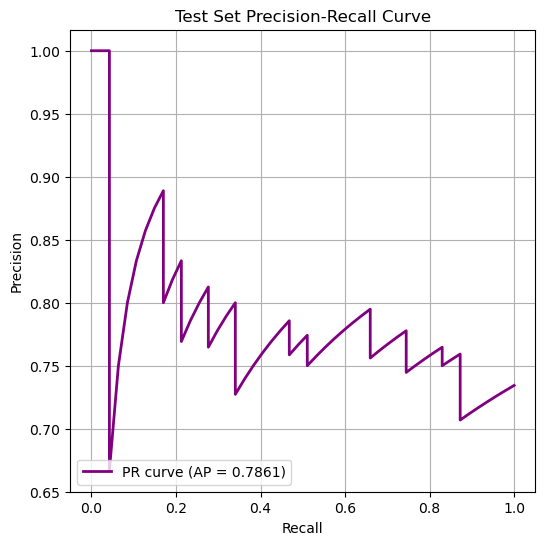

Test Average Precision (AP): 0.7861


In [16]:
# ==========================================================
# 8. ROC CURVE + AUC
# ==========================================================
from sklearn.metrics import roc_curve, auc, roc_auc_score

def plot_roc_curve(y_true, y_prob, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color="darkorange", lw=2,
             label=f"ROC curve (AUC = {roc_auc:.4f})")
    plt.plot([0,1], [0,1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# Call after predictions
plot_roc_curve(df_pred["label"].values, df_pred["p1"].values,
               title="Test Set ROC Curve")

auc_score = roc_auc_score(df_pred["label"], df_pred["p1"])
print(f"Test AUC: {auc_score:.4f}")

# ==========================================================
# 9. PRECISION-RECALL CURVE
# ==========================================================
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_pr_curve(y_true, y_prob, title="Precision-Recall Curve"):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)

    plt.figure(figsize=(6,6))
    plt.plot(recall, precision, color="purple", lw=2,
             label=f"PR curve (AP = {ap:.4f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()

# Call after predictions
plot_pr_curve(df_pred["label"].values, df_pred["p1"].values,
              title="Test Set Precision-Recall Curve")

ap_score = average_precision_score(df_pred["label"], df_pred["p1"])
print(f"Test Average Precision (AP): {ap_score:.4f}")